In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import cv2
import csv
import random
from sklearn.decomposition import PCA
import os
import pandas as pd
import numpy as np
import random
import time
from keras.applications import ResNet50, MobileNetV2, VGG16
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Input
from keras.preprocessing.image import img_to_array
from keras.applications import Xception
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.preprocessing import image

from keras import backend, layers, metrics

from keras.optimizers import Adam
from keras.applications import Xception
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

from keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
data_dir = '/content/drive/MyDrive/COMP90086_2023_TLLdataset' # Change the location of the datadirectory to where the data is located

# Load the "left" train images
train_left_image_dir = os.path.join(data_dir, 'train', 'left')
train_left_image_paths = [os.path.join(train_left_image_dir, filename) for filename in os.listdir(train_left_image_dir)]

# Load the "right" train images
train_right_image_dir = os.path.join(data_dir, 'train', 'right')
train_right_image_paths = [os.path.join(train_right_image_dir, filename) for filename in os.listdir(train_right_image_dir)]

total_train_image_paths = train_left_image_paths + train_right_image_paths

# Load the "left" test images
test_left_image_dir = os.path.join(data_dir, 'test', 'left')
test_left_image_paths = [os.path.join(test_left_image_dir, filename) for filename in os.listdir(test_left_image_dir)]

# Load the "right" test images
test_right_image_dir = os.path.join(data_dir, 'test', 'right')
test_right_image_paths = [os.path.join(test_right_image_dir, filename) for filename in os.listdir(test_right_image_dir)]

total_test_image_paths = test_left_image_paths + test_right_image_paths


# Define the path to your train CSV file
csv_file_path = data_dir+"/train.csv"

# Read the train CSV file into a DataFrame
train_df = pd.read_csv(csv_file_path)
left_image_names = train_df['left']
right_image_names = train_df['right']


In [ ]:
# CREATE TRAIN DATASET IDENTICAL TO TEST CANDIDATES
paired_df = pd.DataFrame(columns=["left", "c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19"])

# Create an empty list to store DataFrames to be concatenated
dfs_to_concat = []

for index, row in train_df.iterrows():
    left_image = row['left']
    correct_right_image = row['right']
    # Calculate the starting index for false images
    start_index = index + 1

    # Initialize a list to store possible images
    false_images = [correct_right_image]

    # Iterate through 19 images (including wrapping around to the start)
    for i in range(19):
        # Use modulus to wrap around to the start of the list when needed
        false_image_index = (start_index + i) % len(right_image_names)
        false_image = right_image_names[false_image_index]
        false_images.append(false_image)

    random.shuffle(false_images)
    row = [left_image] + false_images

    # Append the row as a DataFrame to the list
    df_row = pd.DataFrame([row], columns=paired_df.columns)
    dfs_to_concat.append(df_row)

# Concatenate all the DataFrames in the list into the final paired_df
paired_df = pd.concat(dfs_to_concat, ignore_index=True)

In [ ]:
def calculate_similarity_score(df, image_embeddings):
    j = 0
    # Create an empty list to store the similarity scores for each row
    similarity_scores_list = []

    for index, row in df.iterrows():
        print(j)
        j+=1
        # Create a dictionary to store the similarity scores for the current row
        similarity_scores = {'left': row['left']}

        # Iterate through candidate images (c0 to c19) for the current row
        for i in range(20):
            # Calculate the similarity score between the 'left' image and candidate image
            score = cosine_similarity(image_embeddings[row['left']], image_embeddings[row[f'c{i}']])
            # Store the similarity score in the dictionary
            similarity_scores[f'c{i}'] = score[0][0]
        # Append the similarity scores for the current row to the list
        similarity_scores_list.append(similarity_scores)

    # Create a DataFrame from the list of dictionaries
    similarity_scores_df = pd.DataFrame(similarity_scores_list)

    return similarity_scores_df

def calculate_top2_correct_percentage(output_df):
  correct_predictions = 0  # Initialize a counter for correct predictions
  top_k = 2  # Consider the top max 2 predictions
  correct_matches = []
  false_matches = []
  for i in range(len(output_df)):
      # Get the indices of the top k predictions
      top_k_indices = output_df.iloc[i].values[1:].argsort()[-top_k:]

      # Get the corresponding predicted right pairs
      predicted_right_pairs = [paired_df.iloc[i][f'c{index}'] for index in top_k_indices]

      correct_right_pair = train_df['right'][i]
      if correct_right_pair in predicted_right_pairs:
          correct_matches.append([output_df.iloc[i]['left'], predicted_right_pairs])
          correct_predictions += 1
      else:
          false_matches.append([output_df.iloc[i]['left'], predicted_right_pairs])


  # Calculate the percentage of correct predictions
  total_predictions = len(output_df)
  correct_percentage = (correct_predictions / total_predictions) * 100

  print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
  print(f"Correct Percentage: {correct_percentage:.2f}%")
  return correct_matches, false_matches

# Canny edge detection
def canny_edge_detection(total_image_paths):
    predicted_embeddings = {}
    threshold1 = 50
    threshold2 = 150
    i=0
    for path in total_image_paths:
      print(i)
      i+=1
      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      blurred = cv2.GaussianBlur(image, (5, 5), 0)
      edges = cv2.Canny(blurred, threshold1, threshold2)
      predicted_embeddings[path.split('/')[-1].replace('.jpg', '')] = edges
    return predicted_embeddings

**METHOD 1 : CANNY EDGE DETECTOR BASED IMAGE COMPARISON**

In [ ]:
train_image_edges = canny_edge_detection(total_train_image_paths)
train_edges_output_df = calculate_similarity_score(paired_df, train_image_edges)


Streaming output truncated to the last 5000 lines.
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189

Correct Predictions: 209/2000
Correct Percentage: 10.45%


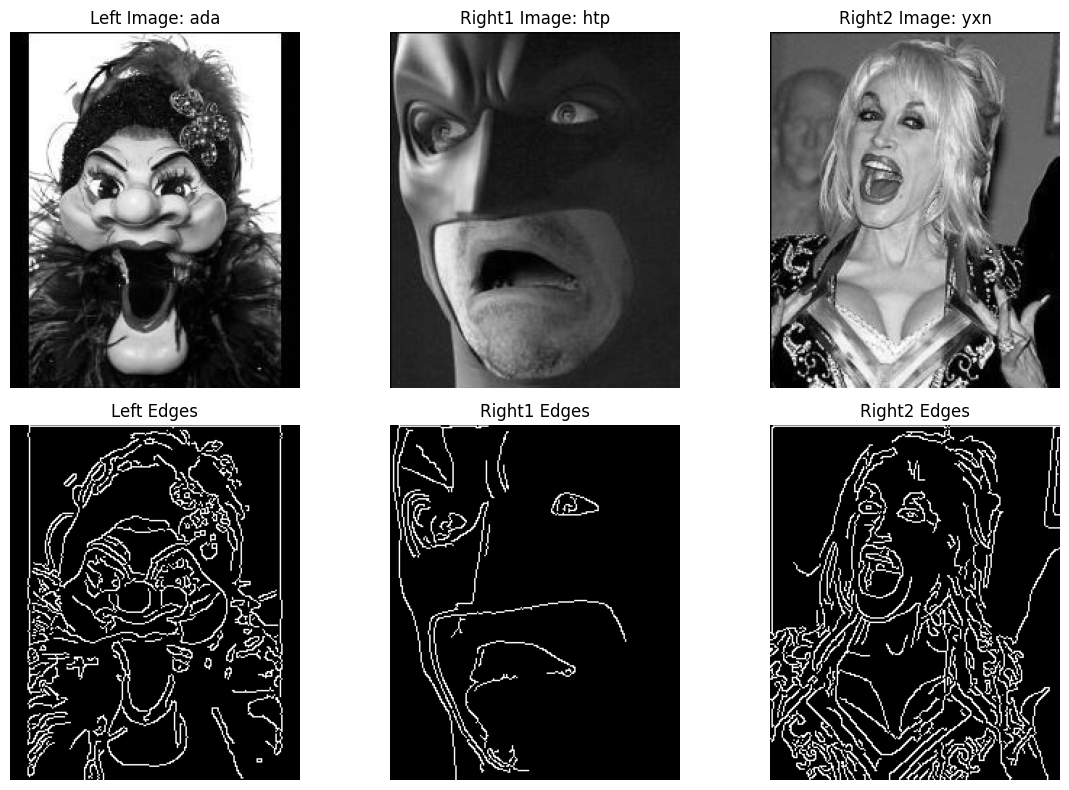

Cosine Similarity between left and right1 edges: 0.0
Cosine Similarity between left and right2 edges: 0.0


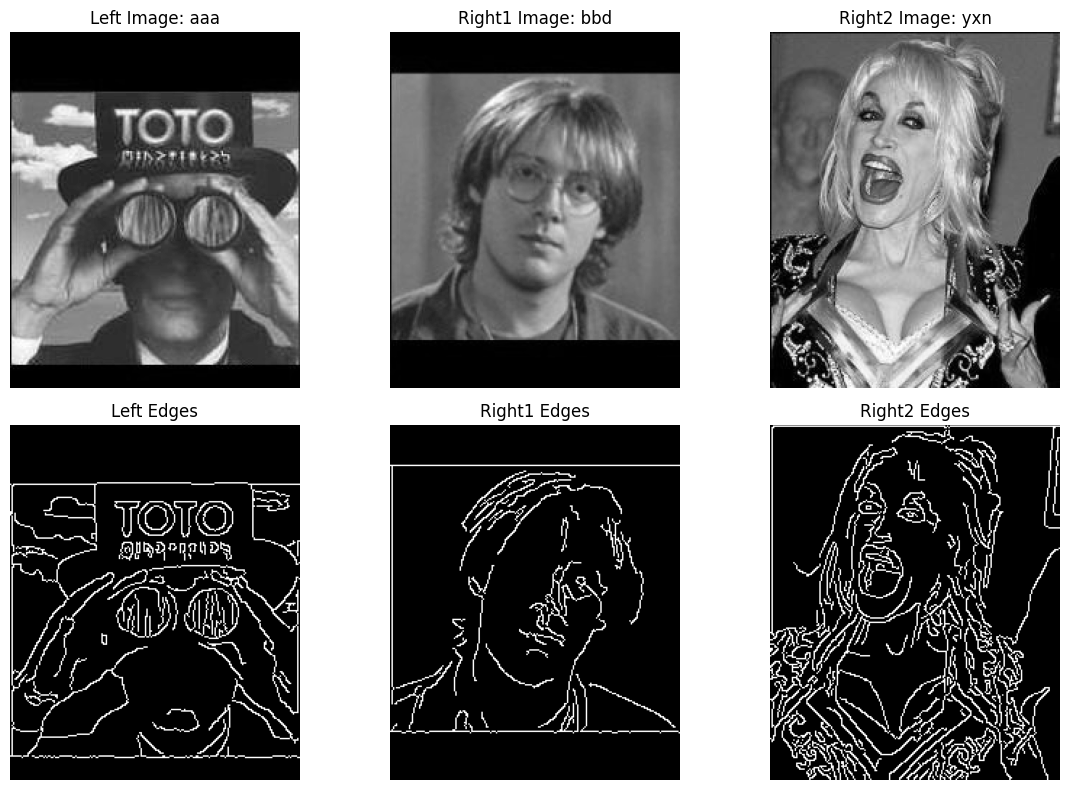

Cosine Similarity between left and right1 edges: 0.0
Cosine Similarity between left and right2 edges: 0.0


In [ ]:
correct_matches_edges, false_matches_edges = calculate_top2_correct_percentage(train_edges_output_df)
def display_sample_edge_image(samples):
  for sample in samples:
    left_image = cv2.imread(os.path.join(train_left_image_dir, sample[0] + '.jpg'), cv2.IMREAD_GRAYSCALE)
    left_blurred = cv2.GaussianBlur(left_image, (5, 5), 0)
    left_edges = cv2.Canny(left_blurred, 50, 150)

    right1_image = cv2.imread(os.path.join(train_right_image_dir, sample[1][0] + '.jpg'), cv2.IMREAD_GRAYSCALE)
    right1_blurred = cv2.GaussianBlur(right1_image, (5, 5), 0)
    right1_edges = cv2.Canny(right1_blurred, 50, 150)

    right2_image = cv2.imread(os.path.join(train_right_image_dir, sample[1][1] + '.jpg'), cv2.IMREAD_GRAYSCALE)
    right2_blurred = cv2.GaussianBlur(right2_image, (5, 5), 0)
    right2_edges = cv2.Canny(right2_blurred, 50, 150)

    # Create a figure with a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Display the left image and its edges in the first column
    axes[0, 0].imshow(left_image, cmap='gray')
    axes[0, 0].set_title(f'Left Image: {sample[0]}')
    axes[1, 0].imshow(left_edges, cmap='gray')
    axes[1, 0].set_title('Left Edges')

    # Display the right1 image and its edges in the second column
    axes[0, 1].imshow(right1_image, cmap='gray')
    axes[0, 1].set_title(f'Right1 Image: {sample[1][0]}')
    axes[1, 1].imshow(right1_edges, cmap='gray')
    axes[1, 1].set_title('Right1 Edges')

    # Display the right2 image and its edges in the third column
    axes[0, 2].imshow(right2_image, cmap='gray')
    axes[0, 2].set_title(f'Right2 Image: {sample[1][1]}')
    axes[1, 2].imshow(right2_edges, cmap='gray')
    axes[1, 2].set_title('Right2 Edges')

    # Remove axis labels
    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Compute cosine similarity between left edge and right1 edge
    similarity_left_right1 = cosine_similarity(left_edges, right1_edges)

    # Compute cosine similarity between left edge and right2 edge
    similarity_left_right2 = cosine_similarity(left_edges, right2_edges)

    print(f"Cosine Similarity between left and right1 edges: {similarity_left_right1[0][0]}")
    print(f"Cosine Similarity between left and right2 edges: {similarity_left_right2[0][0]}")
correct_match_sample_edge = correct_matches_edges[0]  # Sample Correct pair
false_match_sample_edge = false_matches_edges[0] # Sample False pair
samples = [correct_match_sample_edge, false_match_sample_edge]
display_sample_edge_image(samples)
sample_correct_row = paired_df[paired_df['left']==false_match_sample_edge[0]]

# Note: the first pair of images showed are a correct match and the 2nd are a false match


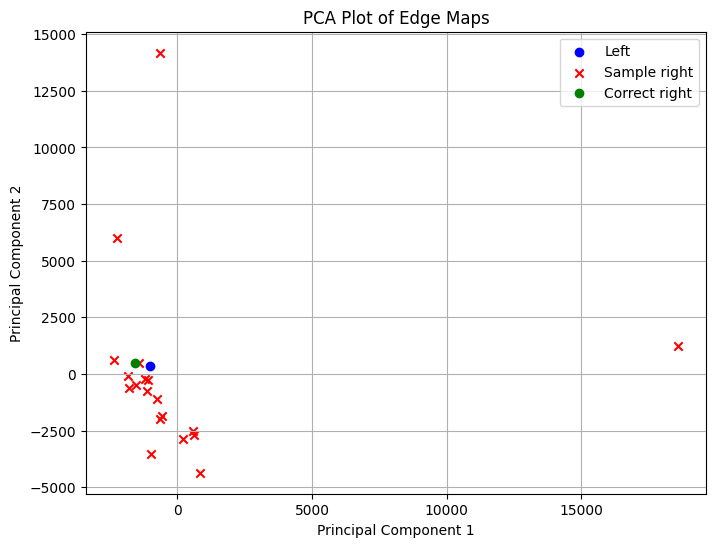

In [ ]:
# Assuming 'left' column contains the filename of the left image
left_image_path = os.path.join(train_left_image_dir, sample_correct_row['left'].iloc[0] + '.jpg')
left_image = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
left_blurred = cv2.GaussianBlur(left_image, (5, 5), 0)
left_edges = cv2.Canny(left_blurred, 50, 150)

# Create an empty list to store the right images
right_edges = []

# Iterate through the 'c0' to 'c19' columns to load and process the right images
for col in sample_correct_row.columns[1:]:
    right_image_path = os.path.join(train_right_image_dir, sample_correct_row[col].iloc[0] + '.jpg')
    right_image = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
    right_blurred = cv2.GaussianBlur(right_image, (5, 5), 0)
    right_edge = cv2.Canny(right_blurred, 50, 150)
    right_edges.append(right_edge)

# Convert the left and right edges to numpy arrays
left_edges_array = np.array(left_edges)
right_edges_array = np.array(right_edges)

# Flatten the edges to create data matrices for PCA
left_edges_flattened = left_edges_array.reshape(1, -1)  # Reshape into a 1D array
right_edges_flattened = right_edges_array.reshape(len(right_edges_array), -1)  # Reshape each right edge into 1D arrays

# Combine the left and right data matrices
data_matrix = np.vstack([left_edges_flattened, right_edges_flattened])

# Perform PCA
pca = PCA(n_components=2)  # You can adjust the number of components
pca_result = pca.fit_transform(data_matrix)

# Create a scatter plot with points for the images
fig, ax = plt.subplots(figsize=(8, 6))

# Get the legend labels from the DataFrame values
legend_labels = [sample_correct_row['left'].iloc[0]] + sample_correct_row.iloc[0, 1:].tolist()

# Find the correct right pair in the DataFrame
correct_pair = train_df[train_df['left'] == sample_correct_row['left'].iloc[0]]
correct_right_image = correct_pair['right'].iloc[0]

# Plot the left image as a blue dot
ax.scatter(pca_result[0, 0], pca_result[0, 1], label='Left', c='b', marker='o')

# Plot the right images as red crosses
labelled_once = False
for i in range(len(right_edges)):
    if legend_labels[i + 1] == correct_right_image:
        # Plot the correct right pair as a blue cross
        ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], label='Correct right', c='g', marker='o')

    else:
      if not labelled_once:
        ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], label='Sample right', c='r', marker='x')
        labelled_once = True
      else:
         ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], c='r', marker='x')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot of Edge Maps')
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
# Finding the similarity scores for the test_candidates using the canny edge detector
test_image_edges = canny_edge_detection(total_test_image_paths)
test_candidates_df = pd.read_csv(f'{data_dir}/test_candidates.csv')
test_edges_output_df = calculate_similarity_score(test_candidates_df, test_image_edges)
test_edges_output_df.to_csv('predictions_canny.csv', index=False)

Streaming output truncated to the last 5000 lines.
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189

**METHOD 2 : Pre-Trained Model**

In [ ]:
target_shape = (200, 245, 3)

base_model = Xception(weights='imagenet', include_top=False, input_shape=target_shape)

for layer in base_model.layers:
    layer.trainable = False

# Add a flatten layer
x = base_model.output
x = Flatten()(x)

# Create a new model
image_encoder_model = Model(inputs=base_model.input, outputs=x)

# Load the test data

def read_image(path, preprocess=False):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (245, 200))

    if preprocess:
      image = np.expand_dims(image, axis=0)
      image = preprocess_input(np.array(image))

    return image

def load_image_batch(image_paths):
    img_list = []
    for img_path in image_paths:
        img = read_image(img_path)
        img = preprocess_input(np.array(img))
        img_list.append(img)


    return np.array(img_list)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
test = 'test' # change this to 'train' to excute the method on the model test dataset

if test == 'test':
  test_df = pd.read_csv(f'{data_dir}/test_candidates.csv')
else:
  test_df = paired_df

# Predict the similarity scores for the test data
predictions = []
i=0
for _, row in test_df.iterrows():
    print(i)
    i+=1
    left_image = row['left']
    right_images = [row['c' + str(i)] for i in range(20)]

    # Load a batch of 'right' images
    right_img_batch = load_image_batch([f'{data_dir}/{test}/right/' + img + '.jpg' for img in right_images]) # candidates

    # Repeat the 'left' image to match the number of 'right' images
    left_img = read_image(f'{data_dir}/{test}/left/' + left_image + '.jpg', True)

    # Predict the distances for the batch of image pairs
    right_image_encodings = image_encoder_model.predict(right_img_batch)
    left_image_encoding = image_encoder_model.predict(left_img)

    # Convert distances to similarity scores
    scores = cosine_similarity(right_image_encodings, left_image_encoding)

    predictions.append(scores.flatten().tolist())

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['c' + str(i) for i in range(20)])
predictions_df.insert(0, 'left', test_df['left'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictions_pretrained.csv', index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
334
1/1 [==============================] - 0s 32ms/step
335
1/1 [==============================] - 0s 20ms/step
336
1/1 [==============================] - 0s 22ms/step
337
1/1 [==============================] - 0s 19ms/step
338
1/1 [==============================] - 0s 21ms/step
339
1/1 [==============================] - 0s 21ms/step
340
1/1 [==============================] - 0s 21ms/step
341
1/1 [==============================] - 0s 24ms/step
342
1/1 [==============================] - 0s 20ms/step
343
1/1 [==============================] - 0s 21ms/step
344
1/1 [==============================] - 0s 22ms/step
345
1/1 [==============================] - 0s 21ms/step
346
1/1 [==============================] - 0s 20ms/step
347
1/1 [==============================] - 0s 22ms/step
348
1/1 [==============================] - 0s 22ms/step
349
1/1 [==============================] - 0s 20ms/step
3

Correct Predictions: 841/2000
Correct Percentage: 42.05%
1/1 [==============================] - 0s 36ms/step


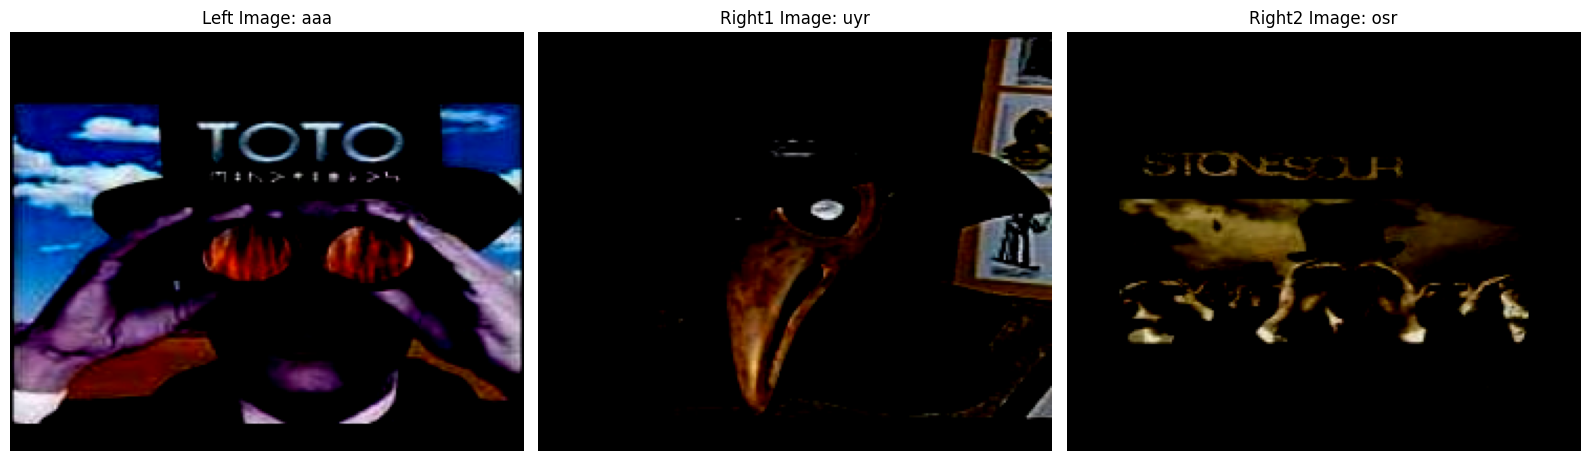

Cosine Similarity between left and right1 edges: 0.3377089500427246
Cosine Similarity between left and right2 edges: 0.3556646406650543
1/1 [==============================] - 0s 26ms/step


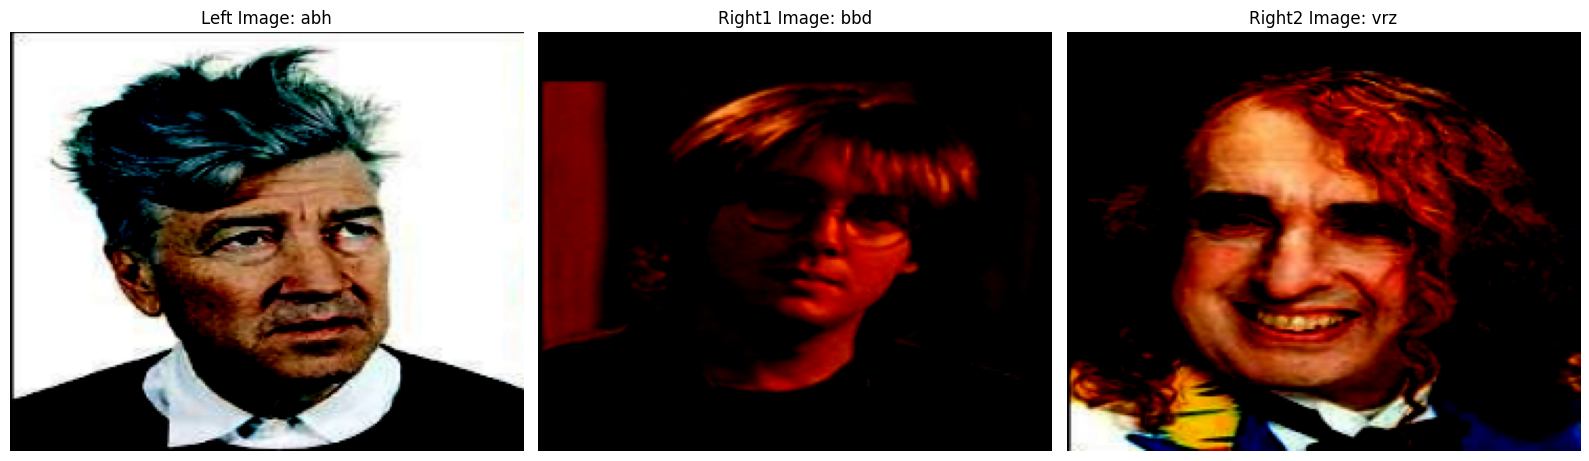

Cosine Similarity between left and right1 edges: 0.39949116110801697
Cosine Similarity between left and right2 edges: 0.4237203896045685
1/1 [==============================] - 0s 25ms/step


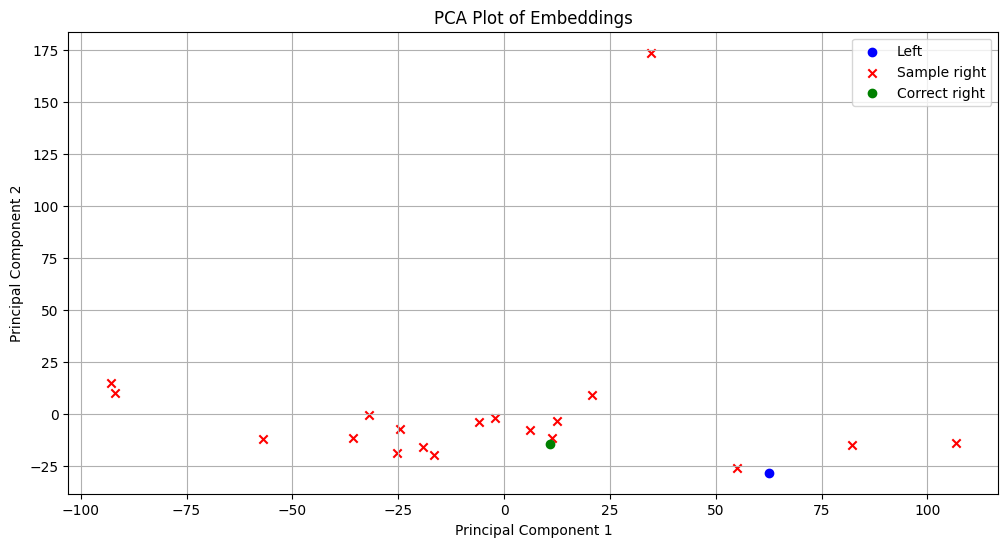

In [ ]:
############ The code in the this block is for the model test dataset ####################
# Note: the first pair of images showed are a correct match and the 2nd are a false match




if test == 'train':
  correct_matches, false_matches = calculate_top2_correct_percentage(predictions_df)
  def display_sample_embedding_image(samples):
      for sample in samples:
          left_image = read_image(os.path.join(train_left_image_dir, sample[0] + '.jpg'), True)
          left_embeddings = image_encoder_model.predict(left_image)

          right1_image = read_image(os.path.join(train_right_image_dir, sample[1][0] + '.jpg'), True)
          right1_embeddings = image_encoder_model.predict(right1_image)

          right2_image = read_image(os.path.join(train_right_image_dir, sample[1][1] + '.jpg'), True)
          right2_embeddings = image_encoder_model.predict(right2_image)

          # Create a figure with a 1x3 grid of subplots
          fig, axes = plt.subplots(1, 3, figsize=(16, 8))

          # Display the left image and its edges in the first column
          axes[0].imshow(left_image[0])
          axes[0].set_title(f'Left Image: {sample[0]}')

          # Display the right1 image and its edges in the second column
          axes[1].imshow(right1_image[0])
          axes[1].set_title(f'Right1 Image: {sample[1][0]}')

          # Display the right2 image and its edges in the third column
          axes[2].imshow(right2_image[0])
          axes[2].set_title(f'Right2 Image: {sample[1][1]}')

          # Remove axis labels
          for ax in axes:
              ax.axis('off')

          plt.tight_layout()
          plt.show()

          # Compute cosine similarity between left edge and right1 edge
          similarity_left_right1 = cosine_similarity(left_embeddings, right1_embeddings)

          # Compute cosine similarity between left edge and right2 edge
          similarity_left_right2 = cosine_similarity(left_embeddings, right2_embeddings)

          print(f"Cosine Similarity between left and right1 edges: {similarity_left_right1[0][0]}")
          print(f"Cosine Similarity between left and right2 edges: {similarity_left_right2[0][0]}")
  loop_exit = True
  for falsepair in false_matches_edges:
    for correctpair in correct_matches:
      if falsepair[0] == correctpair[0] and loop_exit:
        correct_match_sample = correctpair
        loop_exit = False

  false_match_sample = false_matches[0] # Sample False pair
  samples = [correct_match_sample, false_match_sample]
  display_sample_embedding_image(samples)
  sample_correct_row = paired_df[paired_df['left']==correct_match_sample[0]]
  # Assuming 'left' column contains the filename of the left image
  left_image_path = os.path.join(train_left_image_dir, sample_correct_row['left'].iloc[0] + '.jpg')
  left_image = read_image(left_image_path, True)
  left_embed = image_encoder_model.predict(left_image)

  # Create an empty list to store the right images embeddings
  right_embeds = []

  # Iterate through the 'c0' to 'c19' columns to load and process the right images
  for col in sample_correct_row.columns[1:]:
      right_image_path = os.path.join(train_right_image_dir, sample_correct_row[col].iloc[0] + '.jpg')
      right_image = read_image(right_image_path, True)
      right_embed = image_encoder_model.predict(right_image)
      right_embeds.append(right_embed)

  # Convert the left and right embeddings to numpy arrays
  left_embeds_array = np.array(left_embed)
  right_embeds_array = np.array(right_embeds)

  # Flatten the embeddings to create data matrices for PCA
  left_embeds_flattened = left_embeds_array.reshape(1, -1)  # Reshape into a 1D array
  right_embeds_flattened = right_embeds_array.reshape(len(right_embeds_array), -1)  # Reshape each right edge into 1D arrays

  # Combine the left and right data matrices
  data_matrix = np.vstack([left_embeds_flattened, right_embeds_flattened])

  # Perform PCA
  pca = PCA(n_components=2)  # You can adjust the number of components
  pca_result = pca.fit_transform(data_matrix)

  # Create a scatter plot with points for the images
  fig, ax = plt.subplots(figsize=(12, 6))

  # Get the legend labels from the DataFrame values
  legend_labels = [sample_correct_row['left'].iloc[0]] + sample_correct_row.iloc[0, 1:].tolist()

  # Find the correct right pair in the DataFrame
  correct_pair = train_df[train_df['left'] == sample_correct_row['left'].iloc[0]]
  correct_right_image = correct_pair['right'].iloc[0]

  # Plot the left image as a blue dot
  ax.scatter(pca_result[0, 0], pca_result[0, 1], label='Left', c='b', marker='o')

  # Plot the right images as red crosses
  labelled_once = False
  for i in range(len(right_embeds)):
      if legend_labels[i + 1] == correct_right_image:
          # Plot the correct right pair as a blue cross
          ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], label='Correct right', c='g', marker='o')

      else:
        if not labelled_once:
          ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], label='Sample right', c='r', marker='x')
          labelled_once = True
        else:
          ax.scatter(pca_result[i + 1, 0], pca_result[i + 1, 1], c='r', marker='x')

  # Set labels and title
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_title('PCA Plot of Embeddings')
  ax.legend()
  ax.grid(True)

  plt.show()

METHOD 3: Siamese Network

In [ ]:
target_shape = (200, 245, 3)

In [ ]:
# Number of negative samples per positive sample
num_neg_samples = 5

# Load the training data
train_df = pd.read_csv(f'{data_dir}/train.csv')

# Add directory paths and file extension to the image names
train_df['left'] = f"/train/left/" + train_df['left'] + ".jpg"
train_df['right'] = f"/train/right/" + train_df['right'] + ".jpg"

# Rename the columns
train_df.columns = ['anchor', 'positive']


# Get all unique images from both 'anchor' and 'positive'
all_images = pd.concat([train_df['anchor'], train_df['positive']]).unique()

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.05, random_state=42)

# Create a list of negative images for training set
negative_images = np.random.choice(all_images, size=len(train_df)*num_neg_samples, replace=True)

# Function to get a negative sample that is different from anchor and positive
def get_negative(row):
    negatives = []
    for _ in range(num_neg_samples):
        negative = negative_images[row.name]

        while negative in negatives or negative == row['anchor'] or negative == row['positive']:
            # Replace the used image with a new one from all_images
            replacement = np.random.choice(all_images)
            index = np.where(negative_images == negative)
            negative_images[index] = replacement
            negative = replacement

        negatives.append(negative)
    return negatives

# Apply the function to each row
train_df['negatives'] = train_df.apply(get_negative, axis=1)

# Expand the DataFrame to have multiple rows for each set of anchor-positive images, each with a unique negative image
train_df = train_df.explode('negatives')
train_df.rename(columns={'negatives': 'negative'}, inplace=True)

train_triplet = train_df


In [ ]:
train_triplet

anchor              positive              negative
916   /train/left/lxk.jpg  /train/right/bqj.jpg   /train/left/pxm.jpg
916   /train/left/lxk.jpg  /train/right/bqj.jpg   /train/left/eij.jpg
916   /train/left/lxk.jpg  /train/right/bqj.jpg  /train/right/uib.jpg
916   /train/left/lxk.jpg  /train/right/bqj.jpg  /train/right/qyx.jpg
916   /train/left/lxk.jpg  /train/right/bqj.jpg  /train/right/kxj.jpg
...                   ...                   ...                   ...
1126  /train/left/ons.jpg  /train/right/dsy.jpg   /train/left/yiv.jpg
1126  /train/left/ons.jpg  /train/right/dsy.jpg  /train/right/rfx.jpg
1126  /train/left/ons.jpg  /train/right/dsy.jpg  /train/right/nva.jpg
1126  /train/left/ons.jpg  /train/right/dsy.jpg  /train/right/aep.jpg
1126  /train/left/ons.jpg  /train/right/dsy.jpg   /train/left/tug.jpg

[15200 rows x 3 columns]

In [ ]:
val_test = val_df.copy()

val_test.columns = ['left', 'c0'] # we know c0 is the ground truth

val_images = pd.concat([val_df['anchor'], val_df['positive']]).unique()
def get_random_image(exclude_list):
    available_images = list(set(val_images) - set(exclude_list))
    return random.choice(available_images)

# Add c1 through c19 columns with random images
for i in range(1, 20):
    val_test[f'c{i}'] = val_test.apply(lambda row: get_random_image([row['left'], row['c0']] + list(row[2:i])), axis=1)
    val_test[f'c{i}'] = val_test.apply(lambda row: get_random_image([row['left'], row['c0']] + list(row[2:i]) + [row[f'c{i}']]), axis=1)

In [ ]:
val_triplet = val_test.iloc[:, :3].copy()
val_triplet.columns = ['anchor', 'positive', 'negative']

In [ ]:
# print(val_triplet)
# print(val_test)

In [ ]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (245, 200))
    return image


def get_batch(df, batch_size=128, preprocess=True):
    batch_steps = len(df)//batch_size

    df = df.sample(frac=1).reset_index(drop=True)

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(df):
            a, p, n = df.iloc[j]
            anchor.append(read_image(data_dir + a))
            positive.append(read_image(data_dir + p))
            negative.append(read_image(data_dir + n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

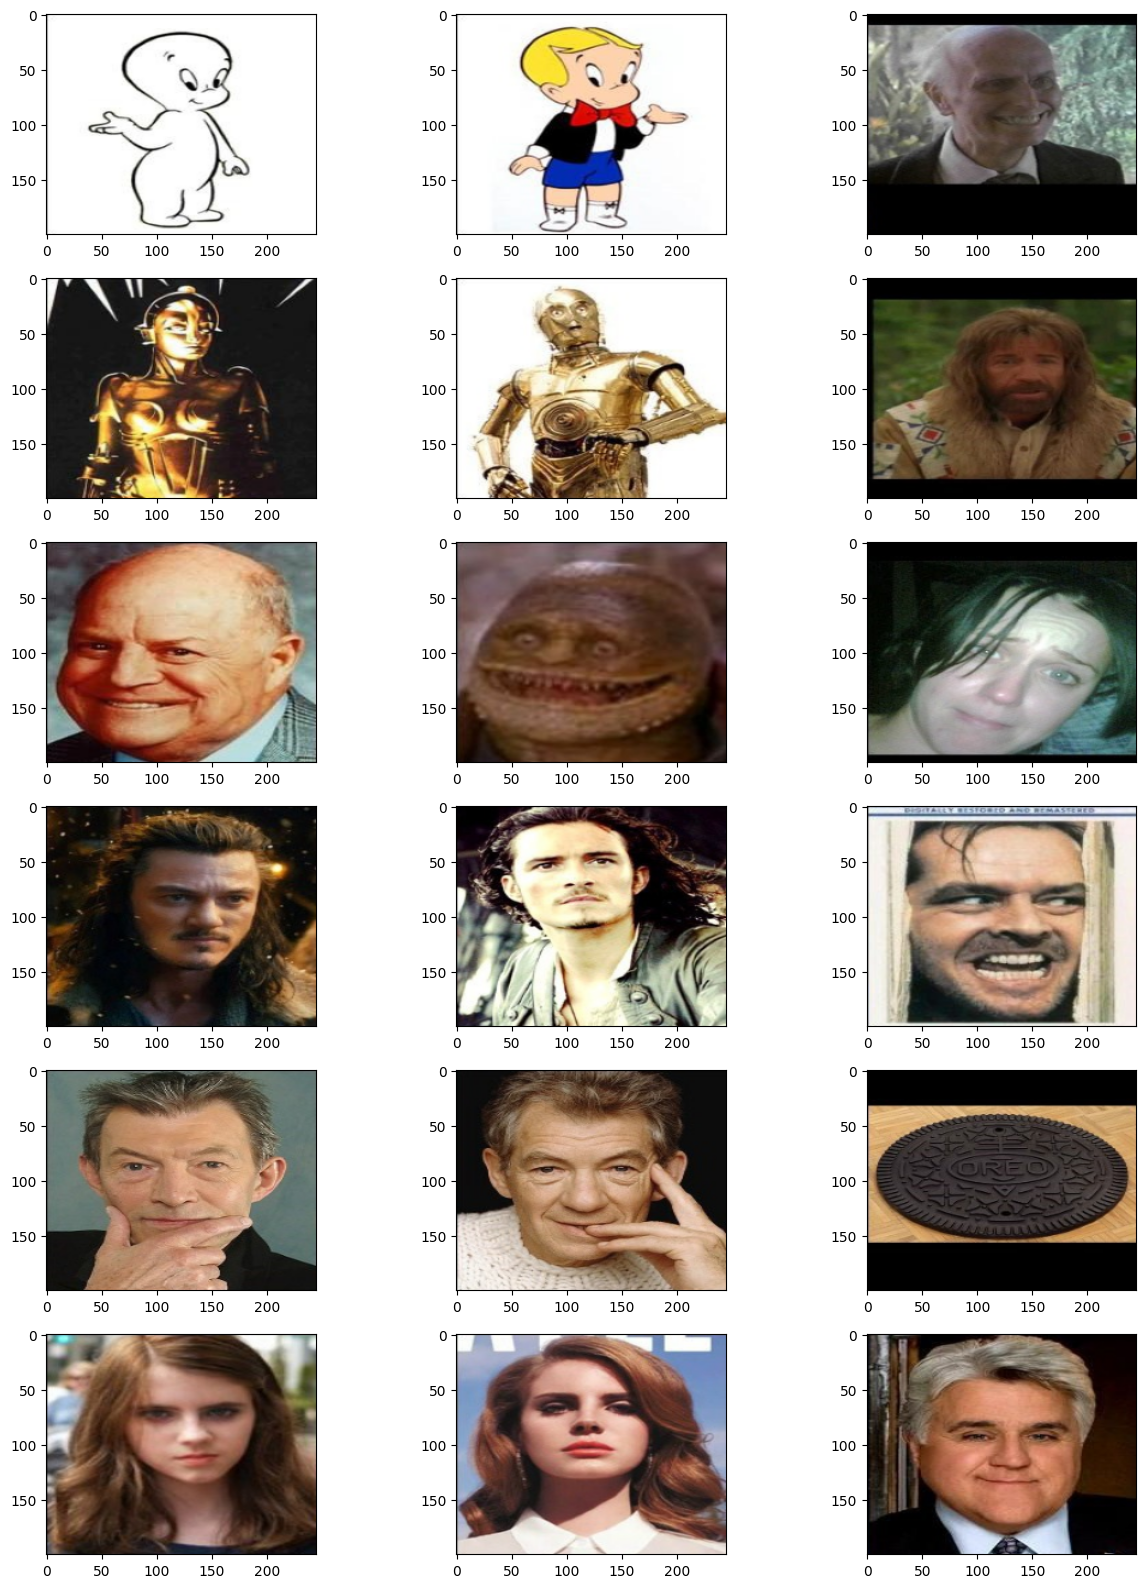

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [ ]:
def get_encoder(input_shape, trainable_from_last=27):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )

    # print(len(pretrained_model.layers))
    for i in range(len(pretrained_model.layers)-trainable_from_last): # Last 'trainable_from_last' layers trainable
        pretrained_model.layers[i].trainable = False
    # for i in range(len(pretrained_model.layers)): # Last 'trainable_from_last' layers trainable
    #   pretrained_model.layers[i].trainable = False


    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))

    ], name="Encode_Model")
    return encode_model

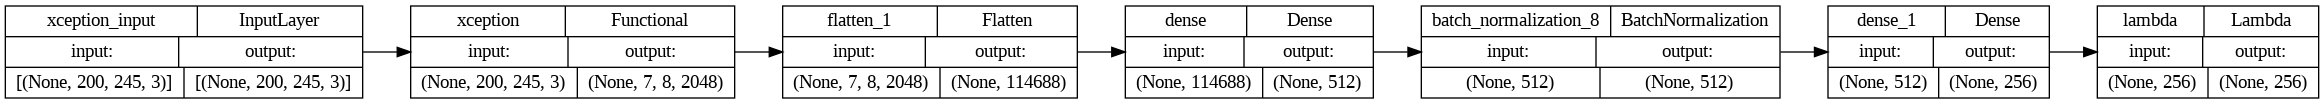

In [ ]:
encoder = get_encoder(target_shape)
plot_model(encoder, show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖² ie Euclidean distance
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = target_shape):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 200, 245, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 200, 245, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 200, 245, 3)]        0         []                            
 )                                                                                                
                                                                                    

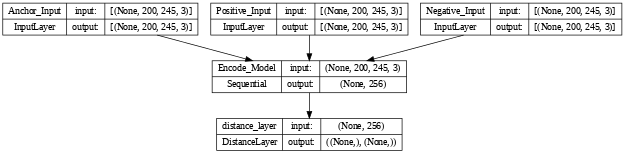

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    # def on_epoch_end(self, epoch, logs=None):
    #     # Perform garbage collection at the end of each epoch
    #     gc.collect()

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [ ]:
def test_on_triplets(data_triplet, batch_size = 128):
    pos_scores, neg_scores = [], []

    for data in get_batch(data_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)

    return accuracy

In [ ]:
save_all = True # note that after training, we will calculate formatted val acc on each epoch
epochs = 5
batch_size = 64

max_acc = 0
train_loss = []
val_loss = []
train_acc = []
val_acc = []

calculate_acc = False

with tf.device('/gpu:0'):
    for epoch in range(1, epochs+1):
        t = time.time()

        print(f"EPOCH {epoch}\n")

        # Training the model on train data
        epoch_train_loss = []
        for i, data in enumerate(get_batch(train_triplet, batch_size=batch_size)):
            loss = siamese_model.train_on_batch(data)
            epoch_train_loss.append(loss)
            print(f"train progress: {((i+1) * batch_size/len(train_triplet) * 100):.3f}%")
        epoch_train_loss = sum(epoch_train_loss)/len(epoch_train_loss)
        train_loss.append(epoch_train_loss)

        epoch_val_loss = []
        for i, data in enumerate(get_batch(val_triplet, batch_size=batch_size)):
            loss = siamese_model.train_on_batch(data)
            epoch_val_loss.append(loss)
            print(f"val progress: {((i+1)* batch_size/len(val_triplet) * 100):.3f}%")

        epoch_val_loss = sum(epoch_val_loss)/len(epoch_val_loss)
        val_loss.append(epoch_val_loss)

        print(f"\n Epoch done in {int(time.time()-t)} sec")
        print(f"Loss on train : {epoch_train_loss:.5f} | Loss on val : {epoch_val_loss:.5f}")
        if save_all:

          print(f"saving siamese model to of epoch {epoch} to siamese_model{epoch}.h5")
          siamese_model.save_weights(f"siamese_model{epoch}.h5")

        if not calculate_acc:
          continue

        acc_train = test_on_triplets(train_triplet, batch_size=batch_size)
        train_acc.append(acc_train)
        # Testing the model on test data
        acc_val = test_on_triplets(val_triplet, batch_size=batch_size)
        val_acc.append(acc_val)
        accuracy = acc_val

        # Saving the best model (based on val acc) weights
        if accuracy>=max_acc:
            siamese_model.save_weights("siamese_model.h5")
            max_acc = accuracy

        print(f"Accuracy on train = {acc_train:.5f} | Accuracy on val = {accuracy:.5f}")
        print("----------\n")

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final.h5")

EPOCH 1

train progress: 0.421%
train progress: 0.842%
train progress: 1.263%
train progress: 1.684%
train progress: 2.105%
train progress: 2.526%
train progress: 2.947%
train progress: 3.368%
train progress: 3.789%
train progress: 4.211%
train progress: 4.632%
train progress: 5.053%
train progress: 5.474%
train progress: 5.895%
train progress: 6.316%
train progress: 6.737%
train progress: 7.158%
train progress: 7.579%
train progress: 8.000%
train progress: 8.421%
train progress: 8.842%
train progress: 9.263%
train progress: 9.684%
train progress: 10.105%
train progress: 10.526%
train progress: 10.947%
train progress: 11.368%
train progress: 11.789%
train progress: 12.211%
train progress: 12.632%
train progress: 13.053%
train progress: 13.474%
train progress: 13.895%
train progress: 14.316%
train progress: 14.737%
train progress: 15.158%
train progress: 15.579%
train progress: 16.000%
train progress: 16.421%
train progress: 16.842%
train progress: 17.263%
train progress: 17.684%
train 

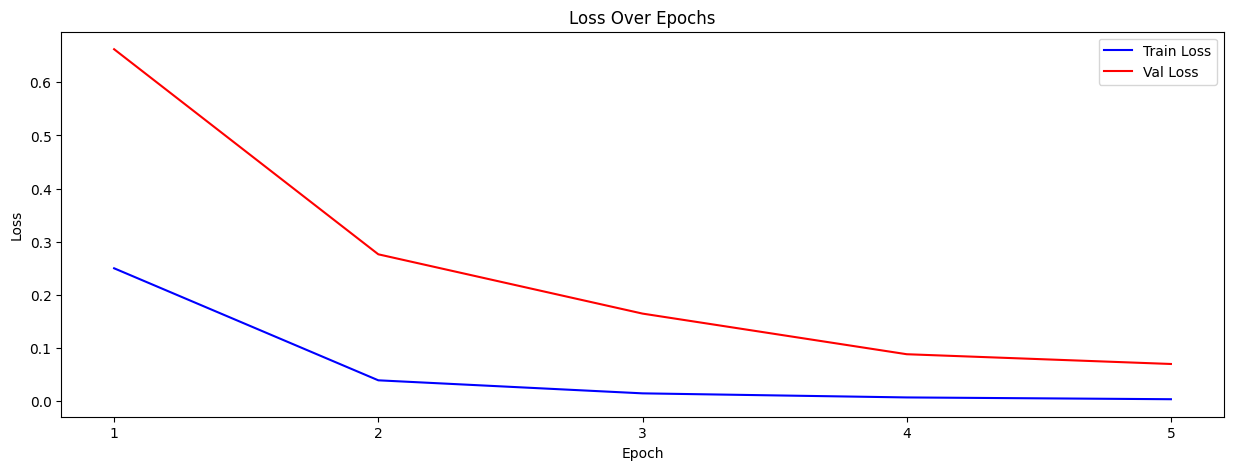

In [ ]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(15, 5))

plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, len(epochs) + 1, 1))  # Set integer x-axis ticks
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

calculating accuracy on formatted validation across epochs:

In [ ]:
'''Load previous network'''
def load_previous_network(path, batch_size =64):
  siamese_network = get_siamese_network()
  siamese_model = SiameseModel(siamese_network)

  # Generate dummy input data with specific shape

  input_shape = (batch_size,) + target_shape
  dummy_input1 = np.zeros(input_shape)
  dummy_input2 = np.zeros(input_shape)
  dummy_input3 = np.zeros(input_shape)

  # Call the model on the dummy data
  siamese_model([dummy_input1, dummy_input2, dummy_input3])

  # Load the weights
  siamese_model.load_weights(path)
  return siamese_model

# siamese_model = load_previous_network("siamese_model1.h5", batch_size = 64)

In [ ]:
def get_inference_model(siamese_model):
    input_1 = layers.Input(target_shape)
    input_2 = layers.Input(target_shape)

    encoded_1 = siamese_model.siamese_network.get_layer('Encode_Model')(input_1)
    encoded_2 = siamese_model.siamese_network.get_layer('Encode_Model')(input_2)

    # # Compute the Euclidean distance between the two encodings
    # distance = layers.Lambda(lambda tensors: tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=-1))([encoded_1, encoded_2])

    # Compute the cosine similarity between the two encodings
    similarity = layers.Dot(axes=-1, normalize=True)([encoded_1, encoded_2])

    return Model(inputs=[input_1, input_2], outputs=similarity)


In [ ]:
# Load the test data
val_df = val_test
total_df_len = len(val_df)

def load_image_batch(image_paths):
    img_list = []
    for img_path in image_paths:
        img = read_image(data_dir + img_path)
        img_list.append(img)

    preprocessed = preprocess_input(np.array(img_list))

    # img_batch = np.array(img_list)

    return preprocessed

top_2_accuracies = []

for epoch_num in range(1,6):
  siamese_model = load_previous_network(f"siamese_model{epoch_num}.h5", batch_size = 64)
  inference_model = get_inference_model(siamese_model)
  correct_predics = 0
  i=0
  for _, row in val_df.iterrows():
      print(i)
      i+=1
      left_image = row['left']
      right_images = [row['c' + str(i)] for i in range(20)]

      # Load a batch of 'right' images
      right_img_batch = load_image_batch([img for img in right_images])

      # Repeat the 'left' image to match the number of 'right' images
      left_img_batch = np.repeat(load_image_batch([left_image]), len(right_images), axis=0)

      # Predict the distances for the batch of image pairs
      similarities = inference_model.predict([left_img_batch, right_img_batch]).flatten()

      top2_indices = np.argsort(similarities)[::-1][:2]
      # print(similarities)
      # print(top2_indices)
      # print("---")

      if 0 in top2_indices:
        correct_predics += 1

  top_2_acc = correct_predics / total_df_len
  print(f"epoch{epoch_num} top 2 accuracy: {top_2_acc}")
  top_2_accuracies.append(top_2_acc)


0
1/1 [==============================] - 4s 4s/step
1
1/1 [==============================] - 0s 41ms/step
2
1/1 [==============================] - 0s 39ms/step
3
1/1 [==============================] - 0s 47ms/step
4
1/1 [==============================] - 0s 44ms/step
5
1/1 [==============================] - 0s 41ms/step
6
1/1 [==============================] - 0s 45ms/step
7
1/1 [==============================] - 0s 42ms/step
8
1/1 [==============================] - 0s 43ms/step
9
1/1 [==============================] - 0s 38ms/step
10
1/1 [==============================] - 0s 38ms/step
11
1/1 [==============================] - 0s 38ms/step
12
1/1 [==============================] - 0s 36ms/step
13
1/1 [==============================] - 0s 37ms/step
14
1/1 [==============================] - 0s 37ms/step
15
1/1 [==============================] - 0s 36ms/step
16
1/1 [==============================] - 0s 36ms/step
17
1/1 [==============================] - 0s 37ms/step
18
1/1 [==============

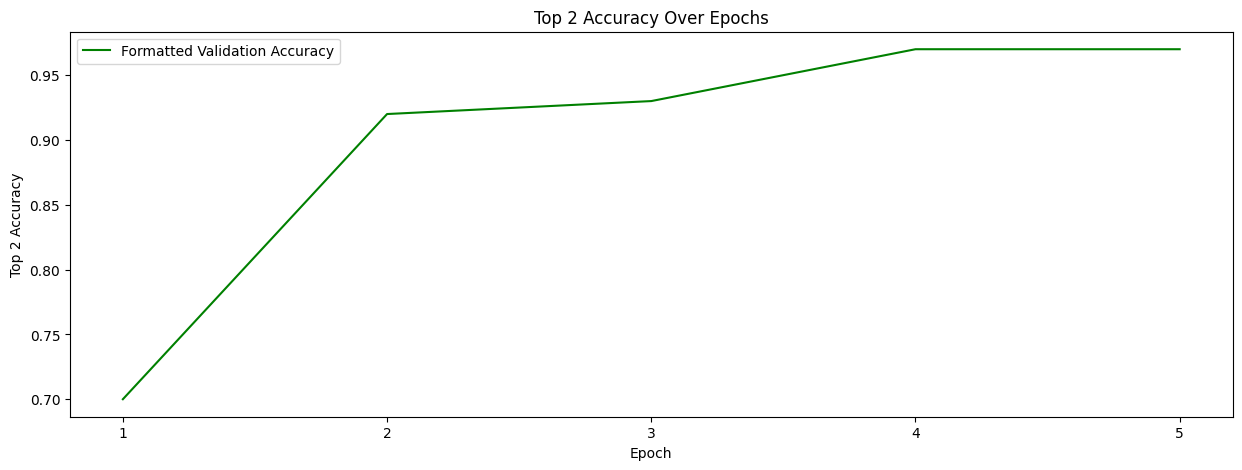

In [ ]:
epochs = range(1, len(top_2_accuracies) + 1)

plt.figure(figsize=(15, 5))

plt.plot(epochs, top_2_accuracies, 'g', label='Formatted Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, len(epochs) + 1, 1))  # Set integer x-axis ticks
plt.ylabel('Top 2 Accuracy')
plt.title('Top 2 Accuracy Over Epochs')
plt.legend()

Inference on real test set

In [ ]:
siamese_model = load_previous_network("siamese_model-final.h5", batch_size)
inference_model = get_inference_model(siamese_model)

In [ ]:
# Load the test data
test_df = pd.read_csv(f'{data_dir}/test_candidates.csv')

def load_image_batch(image_paths):
    img_list = []
    for img_path in image_paths:
        img = read_image(data_dir + img_path)
        img_list.append(img)

    preprocessed = preprocess_input(np.array(img_list))

    return preprocessed

# Predict the similarity scores for the test data
predictions = []
i=0
for _, row in test_df.iterrows():
    print(i)
    i+=1
    left_image = row['left']
    right_images = [row['c' + str(i)] for i in range(20)]

    # Load a batch of 'right' images
    right_img_batch = load_image_batch([f'/test/right/' + img + '.jpg' for img in right_images])

    # Repeat the 'left' image to match the number of 'right' images
    left_img_batch = np.repeat(load_image_batch([f'/test/left/' + left_image + '.jpg']), len(right_images), axis=0)

    # Predict the distances for the batch of image pairs
    similarities = inference_model.predict([left_img_batch, right_img_batch]).flatten()


    predictions.append(similarities.tolist())

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['c' + str(i) for i in range(20)])
predictions_df.insert(0, 'left', test_df['left'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictions_siamese.csv', index=False) # download this for final predcitions
# !cp predictions.csv /content/drive/MyDrive

0
1/1 [==============================] - 1s 1s/step
1
1/1 [==============================] - 0s 37ms/step
2
1/1 [==============================] - 0s 37ms/step
3
1/1 [==============================] - 0s 38ms/step
4
1/1 [==============================] - 0s 37ms/step
5
1/1 [==============================] - 0s 38ms/step
6
1/1 [==============================] - 0s 38ms/step
7
1/1 [==============================] - 0s 39ms/step
8
1/1 [==============================] - 0s 36ms/step
9
1/1 [==============================] - 0s 39ms/step
10
1/1 [==============================] - 0s 35ms/step
11
1/1 [==============================] - 0s 38ms/step
12
1/1 [==============================] - 0s 37ms/step
13
1/1 [==============================] - 0s 36ms/step
14
1/1 [==============================] - 0s 37ms/step
15
1/1 [==============================] - 0s 39ms/step
16
1/1 [==============================] - 0s 38ms/step
17
1/1 [==============================] - 0s 40ms/step
18
1/1 [==============